Cells below were created as notes while watching Andrej Karpathy's video "[Let's build GPT: from scratch, in code, spelled out.
](https://www.youtube.com/watch?v=kCc8FmEb1nY)". Check it out if you haven't!


### Tokens - encoding text to a numeric format

Tokens are numerical representations of the smallest meaningful units of text in natural language. They can represent words, subwords, characters or even symbols.


As an example, let's look at the tokens used in GPT-2:


In [36]:
from transformers import GPT2Tokenizer

# This is the tokenizer used by GPT-2.
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

test_str = "A string to demonstrate the tokenizer."

# GPT-2 used a subword tokenizer, meaning that each token corresponds to part of a word
str_enc = tokenizer.encode(test_str)  # Tokenized string
print([tokenizer.decode([s]) for s in str_enc])
print(str_enc)


['A', ' string', ' to', ' demonstrate', ' the', ' token', 'izer', '.']
[32, 4731, 284, 10176, 262, 11241, 7509, 13]


As can be seen, the text was split into pieces corresponding to a combination of words, subwords and special characters and converted into tokens in the form of integers.


The set of available tokens is called the _vocabulary_.


In [37]:
from random import sample

# Let's decode a few tokens back to text and print them...
tokens = tokenizer.get_vocab().keys()
print([tokenizer.convert_tokens_to_string([t]) for t in sample(tokens, 20)])

print(f"Vocab size: {tokenizer.vocab_size}")


[' arts', 'Jen', ' labeled', ' IB', ' hash', '886', ' achievement', ' apparently', 'ted', ' jurisdictions', 'gun', ' mods', ' comments', ' Ralph', 'elo', 'Lee', ' colder', 'Cl', 'ypes', 'gomery']
Vocab size: 50257


In [38]:
# For this tokenizer, tokens correspond to subwords. Because of this, the encoded sequence is longer than the amount of words in the text.
print(f"Length of text: {len(test_str.split(' '))}")
print(f"Length of encoded seq: {len(str_enc)}")


Length of text: 6
Length of encoded seq: 8


For this example, we will be using text from Shakespeare as our corpus.


In [39]:
# Load data
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[:300])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


We will be using a very simple tokenization scheme - encoding single characters as tokens.

Therefore, our vocabulary will consist of all symbols used in the text.


In [40]:
vocab = sorted(list(set(text)))
print("".join(vocab))

vocab_size = len(vocab)
print(f"Vocab size: {vocab_size}")



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size: 65


Note that our vocabulary is much smaller compared to the GPT-2 tokenizer. Keep this in mind as we continue!


In [41]:
# Simple tokenization scheme by using the character's index in the vocabulary as its token.
stoi = {ch: i for i, ch in enumerate(vocab)}  # string-to-integer
itos = {i: ch for i, ch in enumerate(vocab)}  # integer-to-string

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itos[i] for i in l])


Let's encode our original example text again, now using this simple tokenizer


In [42]:
print(encode(test_str))
print(decode(encode(test_str)))


[13, 1, 57, 58, 56, 47, 52, 45, 1, 58, 53, 1, 42, 43, 51, 53, 52, 57, 58, 56, 39, 58, 43, 1, 58, 46, 43, 1, 58, 53, 49, 43, 52, 47, 64, 43, 56, 8]
A string to demonstrate the tokenizer.


Let's check how our encoded sequence compares to the original text in length now.


In [43]:
print(f"Length of text: {len(test_str.split(' '))}")
print(f"Length of encoded seq: {len(encode(test_str))}")


Length of text: 6
Length of encoded seq: 38


See how it is much longer? Since we are using a smaller vocabulary, we must use more tokens to encode our sequences.

This shows the inherent relationship between vocabulary size and sequence length - a smaller vocabulary results in longer sequences.


In [44]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data[:100])


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [45]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


In [46]:
block_size = 16
train_data[: block_size + 1]


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43])

### Bigram model

Let's build arguably the simplest language model possible - a bigram model, which predicts the next token based on the previous token only. This means that we are modeling our text as Markov process, where the probability of the next state (token) only depends on the present state (the previous token),


In [47]:
def get_batch(split, block_size, batch_size):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y


In [48]:
import torch.nn as nn
import torch.nn.functional as F


class LanguageModel(nn.Module):
    def __init__(self, block_size) -> None:
        super().__init__()

        self.block_size = block_size

    def generate(self, idx, num_steps):
        for _ in range(num_steps):
            out = self.forward(idx[..., -block_size:])
            logits = out[0][:, -1, :]

            # Note: Sampling is probabilistic.
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [49]:
class BigramLanguageModel(LanguageModel):
    def __init__(self, vocab_size) -> None:
        super().__init__(block_size=1)

        self.embedding = torch.nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        logits = self.embedding(idx)

        if targets is not None:
            B, T, C = logits.shape
            logits_ = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_, targets)
        else:
            loss = None

        return logits, loss


model = BigramLanguageModel(vocab_size)


In [50]:
batch_size = 4
block_size = 8

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for iter in range(10000):
    xb, yb = get_batch("train", block_size, batch_size)

    logits, loss = model(xb, yb)

    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Train loss: {loss}")


Train loss: 4.673334121704102
Train loss: 2.8838369846343994
Train loss: 2.9208128452301025
Train loss: 2.2955782413482666
Train loss: 2.4941670894622803
Train loss: 2.719326972961426
Train loss: 2.430803060531616
Train loss: 2.773200750350952
Train loss: 3.0460026264190674
Train loss: 2.1674907207489014


In [51]:
output = model.generate(torch.zeros((1, 1), dtype=torch.long), 1000)

print(decode(output[0].tolist()))



Wior hr,
An g
TICor's thane prd hene th mefare ougon!
The
Ishe llathadithatath mem hapad,
sem ICAndr icepemy t crtot Hand d s e, h ngou an'd foreacoldendyse.
By,
TUCHENRGourlotheack nd wenthanring, ume LOnnd Antrs th flen, mocot
LAn pure.
Ang re y,
LUng,
BO:
Thave wharthinimyor sa LIICHESO:
Thiou ndse, s edoueril be? it MED:
FLO:
NG y Ler by thers wiss:
Doue s stofofare thir:
An: Blloustour ph ge st
CE: egosid hid cenderd,
IUS:

Wh,
WAng r d tileetef e wayourceral w he adalouslad ke g. dlily f llloord, d? ss Th t ck keesore hy ld S:
If y my wooracor fathis nd hy, Anomorinst ve hithoththoo d moncuancre pangboouseder owe!
ARe;
THARKilint yongod hious and'det toucullistha d.
That nanf ge ale anep' as INGorede las aver ot amof, d ERDINut h lis od ine d ANGHEDIther Isiat,
JUKnde d sere, fo ot f nn,
BENUFouris ghowisis; amy akeshe sthioreameren an holland'spathat d me, be haitof mes losoked s ghichellath anceshe gan ICHAn.
Thabofrengitll ckigou
HEERDend archinnode. fff ans shedilim n wh, o 

Not that bad, but far from perfect.


Naive way to predict next token is by using the mean of all previous token's embeddings.

$$ \hat{x*t} = f(\Sigma*{i=0}^{t-1} x_i) $$


In [52]:
import torch

torch.manual_seed(1337)

T, C = 6, 4

# Let's create a mock sequence of embedded tokens. Let's give each row incrementing values to more easily see what happens.
x = torch.arange(1, T + 1).view(-1, 1).repeat(1, C).float()

print(x.shape)
print(x)


torch.Size([6, 4])
tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.],
        [6., 6., 6., 6.]])


In [53]:
# Slow way, for-loop...


def mean(x):
    xbow = torch.zeros((T, C))

    for t in range(T):  # For each time step in seq.
        xprev = x[: t + 1, :]
        xbow[t] = torch.mean(xprev, dim=0)

    return xbow


print(mean(x))


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


In [54]:
# Fast way - matrix mult!

wei = torch.tril(torch.ones(T, T))  # Create lower triangular matrix.
print(wei)


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [55]:
# When matmuled with sequence with shape (T, C), we almost get what we want - we get the sum of the rows, but not the mean.
print(wei @ x)


tensor([[ 1.,  1.,  1.,  1.],
        [ 3.,  3.,  3.,  3.],
        [ 6.,  6.,  6.,  6.],
        [10., 10., 10., 10.],
        [15., 15., 15., 15.],
        [21., 21., 21., 21.]])


In [56]:
# To get the mean instead, we normalize each row to sum to 1.
row_norm = wei.sum(dim=1, keepdim=True)
wei = wei / row_norm

print(wei @ x)


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


Let's compare speeds


In [57]:
%%timeit
wei @ x 

2.21 µs ± 169 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [58]:
%%timeit
mean(x)


79.2 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


More than 10x faster, and we are not even using the GPU - not bad


Now, there is one more way to achieve the same outcome using softmax across each row, which normalizes it to sum to 1. To mask out future tokens, we replace their values by -inf first.


In [59]:
tri = torch.tril(torch.ones(T, T))

wei = torch.ones((T, T))
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

print(wei)
print(wei @ x)


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])
tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.5000, 1.5000, 1.5000, 1.5000],
        [2.0000, 2.0000, 2.0000, 2.0000],
        [2.5000, 2.5000, 2.5000, 2.5000],
        [3.0000, 3.0000, 3.0000, 3.0000],
        [3.5000, 3.5000, 3.5000, 3.5000]])


The reason this is interesting is because this approach works regardless of the initial values of the weights matrix.

We can fill it with random values and still get rows that are normalized to 1:


In [60]:
wei = torch.randn((T, T))
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

wei


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7089, 0.2911, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5166, 0.3210, 0.1624, 0.0000, 0.0000, 0.0000],
        [0.1616, 0.3187, 0.1423, 0.3774, 0.0000, 0.0000],
        [0.3024, 0.1149, 0.0874, 0.4666, 0.0287, 0.0000],
        [0.1292, 0.1173, 0.1132, 0.0494, 0.1582, 0.4326]])

TODO: Describe how this can be intepreted as affinities, or coupling, between tokens.


## Self-attention


Now, can we do better than a simple average of the previous tokens? Indeed we can! We can do a weighted sum, where the weights represent the importance of each token. Even better, we can do a _learned_ weighted sum, where the weights are data-dependent.

This is in fact exactly what the mechanism underlying transformers does, so called _self-attention_. It works like this:

1. Each token emits three values: 1) a query _Q_, telling other tokens what it is "looking for", 2) a key _K_, telling other tokens its own identity, and 3) a value _V_, representing the token in the weighted sum. These are all outputs of learned functions, typically `nn.Linear` layers.
2. Every token's query is multiplied through a dot-product with every other token's key, giving the _attention weights_ $\alpha$.
3. The attention weights are used to do a weighted sum of the values to produce the output features.

The image below shows a single token's query interacting with the keys and values of the other tokens:

![Alt text](./images/attention_example.svg)

Remember that for a generative language model like GPT, we only want a given token $x_t$ to interact with the tokens that came before, hence $\alpha_{i>t} = 0$.


Like mentioned above, the queries, keys and values are outputs of `nn.Linear` layers.


In [61]:
head_size = 32

x = torch.randn(T, C)

key = nn.Linear(C, head_size)
query = nn.Linear(C, head_size)
value = nn.Linear(C, head_size)

k = key(x)  # (T, head_size)
q = query(x)  # (T, head_size)
v = value(x)  # (T, head_size)

wei = q @ k.T  # (T, head_size) @ (head_size, T) = (T, T)
wei = wei.masked_fill(tri == 0, -torch.inf)
wei = F.softmax(wei, dim=1)

print(wei)
print(wei @ v)


tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.9165e-01, 4.0835e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1789e-01, 6.5987e-02, 6.1612e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.5868e-06, 1.2830e-02, 9.8440e-01, 2.7620e-03, 0.0000e+00, 0.0000e+00],
        [9.9107e-01, 2.0629e-03, 4.1371e-04, 3.6758e-04, 6.0813e-03, 0.0000e+00],
        [9.7590e-01, 6.9176e-03, 1.0155e-03, 5.5064e-03, 2.5252e-03, 8.1350e-03]],
       grad_fn=<SoftmaxBackward0>)
tensor([[-0.7291,  2.2285,  2.4719,  1.1753,  1.3283, -2.6645,  0.1657, -1.7303,
         -1.5886, -1.9180,  0.2320, -1.8639,  0.8100,  2.0086,  1.2171,  0.0767,
          1.2085, -1.0426, -2.1063, -0.2117,  0.6198, -2.5657, -3.2720, -2.2933,
         -0.4154,  1.4644,  1.3094, -0.0176, -0.9738, -0.8888, -0.6673,  1.0015],
        [-0.2837,  1.2334,  1.3860,  0.5857,  0.4858, -1.5227,  0.0211, -1.1075,
         -0.8909, -1.2555,  0.1499, -1.0270,  0.5117,  1.2732,  0.

In the original transformer paper used a particular implementation of self-attention called _scaled dot-product attention_.

$$
Attention(Q, K, V) = softmax\biggl(\frac{Q K^T}{\sqrt{d}}V\biggr)
$$

<img src="./images/scaled_dot_product_attn.svg" width="256" style="margin:auto"/>


There is one piece still missing - the scaling by $1/\sqrt{d_K}$. This is done in order to ensure a that `wei` has unit variance.


In [62]:
k = torch.randn(T, head_size)
q = torch.randn(T, head_size)
wei = q @ k.T
wei_norm = wei * 1 / head_size**0.5

print(k.var())
print(q.var())
print(wei.var())
print(wei_norm.var())


tensor(1.0999)
tensor(0.9475)
tensor(28.0048)
tensor(0.8751)


Without this normalization, `wei` might not be sufficiently uniform and result in a spiky distribution when fed into the softmax function. This would cause tokens to almost only interact with single other tokens, slowing down learning.


In [63]:
attn = F.softmax(wei.masked_fill(tri == 0, -torch.inf), dim=1)
attn_norm = F.softmax(wei_norm.masked_fill(tri == 0, -torch.inf), dim=1)


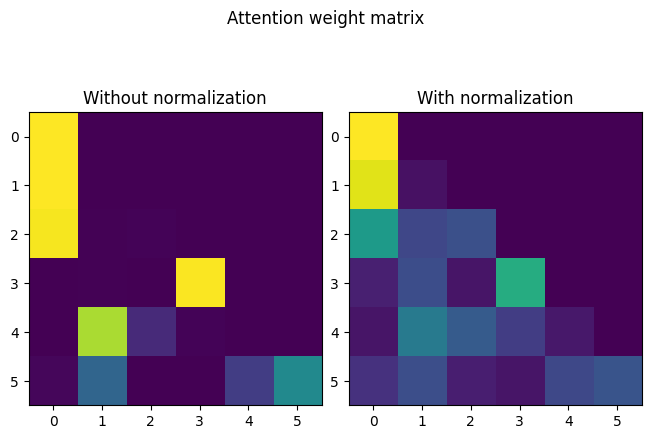

In [64]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, layout="constrained")
axs[0].imshow(attn)
axs[1].imshow(attn_norm)
axs[0].title.set_text("Without normalization")
axs[1].title.set_text("With normalization")
fig.suptitle("Attention weight matrix")
plt.show()


In [65]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, emb_size, head_size, block_size) -> None:
        super().__init__()

        self.head_size = head_size

        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)

        self.register_buffer("tri", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        q = self.query(x)  # (B, T, head_size)
        k = self.key(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        wei = q @ k.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
        wei = wei.masked_fill(self.tri[:T, :T] == 0, -torch.inf)
        wei = F.softmax(wei, dim=1)
        wei = wei * self.head_size**-0.5  # <-- "Scaled"

        out = wei @ v  # (B, T, T) @ (B, T, head_size) = (B, T, head_size)

        return out, wei


Self-attention is typically combined with other layers to form a transformer block. Here is an example of a simple such block:


In [66]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, num_heads=4, block_size=32) -> None:
        super().__init__()

        self.heads = nn.ModuleList(ScaledDotProductAttention(emb_size, head_size, block_size) for _ in range(num_heads))
        self.mlp = nn.Linear(head_size * num_heads, emb_size)

    def forward(self, x):
        head_outs, attns = tuple(map(list, zip(*[head(x) for head in self.heads])))

        emb_cat = torch.cat(head_outs, dim=-1)
        out = x + self.mlp(emb_cat)

        return out, attns


Multiple transformer blocks can be stacked on top of each other to form a deeper network:


In [67]:
B, T, C = 1, 4, 2
x0 = torch.randn(B, T, C)

num_blocks = 4
blocks = [TransformerBlock(C, head_size=32, num_heads=4, block_size=32) for _ in range(num_blocks)]

xs = [x0]
attns = []
for block in blocks:
    x, attn = block(xs[-1])
    xs.append(x)
    attns.append(attn)

print("\n".join([str(x) for x in xs]))


tensor([[[-0.3972,  0.8486],
         [ 1.5318,  0.1125],
         [ 2.2517, -1.4184],
         [ 0.9849,  0.3484]]])
tensor([[[-0.3817,  0.8153],
         [ 1.5173,  0.0970],
         [ 2.1633, -1.2830],
         [ 0.8589,  0.3287]]], grad_fn=<AddBackward0>)
tensor([[[-0.3742,  0.8367],
         [ 1.5257,  0.1388],
         [ 2.2250, -1.1519],
         [ 0.6930,  0.5450]]], grad_fn=<AddBackward0>)
tensor([[[-0.3677,  0.7963],
         [ 1.5444,  0.0960],
         [ 2.2539, -1.1852],
         [ 0.7052,  0.4910]]], grad_fn=<AddBackward0>)
tensor([[[-0.4104,  0.7707],
         [ 1.5211,  0.0739],
         [ 2.2099, -1.2782],
         [ 0.8520,  0.4522]]], grad_fn=<AddBackward0>)


In [71]:
import networkx as nx


def visualize_attention_weights(tokens, attention_weights):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (tokens) to the graph
    for i, token in enumerate(tokens):
        G.add_node(i)

    # Add weighted edges to the graph
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            weight = attention_weights[i][j]
            G.add_edge(i, j, weight=weight)

    # Compute positions for the nodes with reversed order
    pos = {i: (len(tokens) - 1 + i, 0) for i, token in enumerate(tokens)}

    # Draw the graph
    nx.draw_networkx_nodes(G, pos)

    # Draw the edges with opacity based on attention weights
    for edge in G.edges(data=True):
        weight = edge[2]["weight"]
        nx.draw_networkx_edges(
            G, pos, edgelist=[(edge[0], edge[1])], connectionstyle="arc3,rad=0.5", alpha=weight, arrowstyle="<-"
        )

    # selfloop_edges = [(e, e) for e in nx.nodes_with_selfloops(G)]
    # nx.draw_networkx_edges(G, pos, edgelist=selfloop_edges)

    # Draw text labels for nodes
    nx.draw_networkx_labels(G, pos, tokens, font_size=12, font_family="sans-serif")


tokens = ["I", "love", "natural", "language", "processing"]
attention_weights = [
    [0.2, 0.5, 0.1, 0.3, 0.1],
    [0.5, 0.5, 0.2, 0.1, 0.2],
    [0.1, 0.2, 0.5, 0.6, 0.1],
    [0.3, 0.1, 0.6, 0.5, 0.3],
    [0.1, 0.2, 0.1, 0.2, 0.1],
]
attention_weights = torch.tensor(attention_weights)
T = attention_weights.shape[0]
tri = torch.tril(torch.ones(T, T))
attention_weights = attention_weights.masked_fill(tri == 0, -torch.inf)
attention_weights = F.softmax(attention_weights, dim=1)


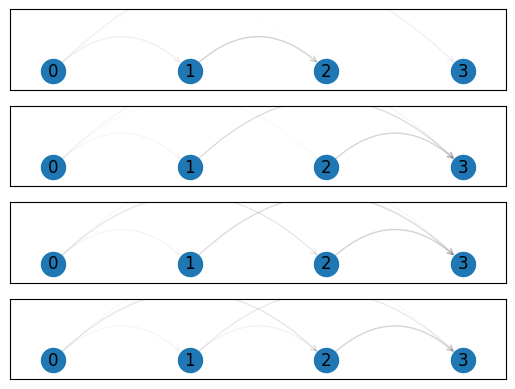

In [83]:
fig, ax = plt.subplots(num_blocks, 1, num=1)

for i, (x, attn) in enumerate(zip(xs, attns)):
    B, T, C = x.shape
    ix = np.unravel_index(i, ax.shape)
    plt.sca(ax[ix])
    visualize_attention_weights({i: i for i in range(T)}, attn[0].tolist()[0])

plt.show()


## Transformer implementation


Let's build a simple transformer!


In [ ]:
class Transformer(LanguageModel):
    def __init__(self, emb_size, vocab_size, head_size, num_heads, block_size, num_blocks) -> None:
        super().__init__(block_size=block_size)

        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pos_emb = nn.Embedding(block_size, emb_size)

        self.blocks = [TransformerBlock(emb_size, head_size, num_heads, block_size) for _ in range(num_blocks)]
        self.out_head = nn.Linear(emb_size, vocab_size)

    def forward(self, x, targets=None):
        B, T = x.shape

        x = self.emb(x) + self.pos_emb(torch.arange(T))

        xs = [x]
        attns = []
        for block in self.blocks:
            x, attn = block(xs[-1])
            xs.append(x)
            attns.append(attn)

        logits = self.out_head(xs[-1])

        if targets is not None:
            B, T, C = logits.shape
            logits_ = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits_, targets)
        else:
            loss = None

        return logits, loss, xs, attns


emb_size = 32
head_size = 32
num_heads = 4
block_size = 16
num_blocks = 4
batch_size = 4

model = Transformer(emb_size, vocab_size, head_size, num_heads, block_size, num_blocks)


In [ ]:
B, T, C = 1, 4, 2
x0 = torch.randn(B, T, C)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for iter in range(int(1e4)):
    xb, yb = get_batch("train", block_size, batch_size)

    logits, loss, xs, attns = model(xb, yb)

    loss.backward()
    optimizer.step()

    if iter % 1000 == 0:
        print(f"Train loss: {loss}")


Train loss: 4.612963676452637
Train loss: 3.3591487407684326
Train loss: 2.683645248413086
Train loss: 2.398271322250366
Train loss: 2.451181650161743
Train loss: 2.6876301765441895
Train loss: 2.532284736633301
Train loss: 2.6978352069854736
Train loss: 2.754011631011963
Train loss: 2.426381826400757


In [ ]:
output = model.generate(torch.zeros((1, 1), dtype=torch.long), 1000)

print(decode(output[0].tolist()))



Thath icofanulat an fl'thisweshene ws here he hesse doumat brfudat wenk shineelish le hy l

I ully: th ut,
y,
re tanglothe youre getu ilen G pll t.
H:
IG'to the sleathe s fow soumast neprfe ithe he co weiifrne gouthouthe ed inst mathe dimaulsoue hewate it s h acontethemee d sstinagretoulme anes h usouthe'lith hatas ut Wh s ore: wateshe hs t?
Thes wer hourothach m'd inantlinout, n t nelit llir t, man che

A:

Tho? mppy t.
BRLL:
The:
An pang tle w outhe t flf tfonthe hell.
Whakn rne od rs omintye the me my, be eventhat
Pr tishawear trentin ouldhepad n be thes se tave the th y y dth; lirild cr, mplyome bathe ousthen than thamusourene bonthemayotly ur' yours gantfaro qula tmaly f n.
Fopandathel yonthe arr t l thes her fe ffangs! me poupo ho s me'd O:


P t fode stmeas tha K: mamalire g it.
MIULer I ghothte the t d the.
AMy my:
I
AUSA: olonfl
 ES: le mitigh d ENu w, ler ciom.

H:

Co Bithichitk somonoutma fend he Juthows teay. pe oul be pldr
n
Gr, daly, herird d, Tay, r hille haimban. nave

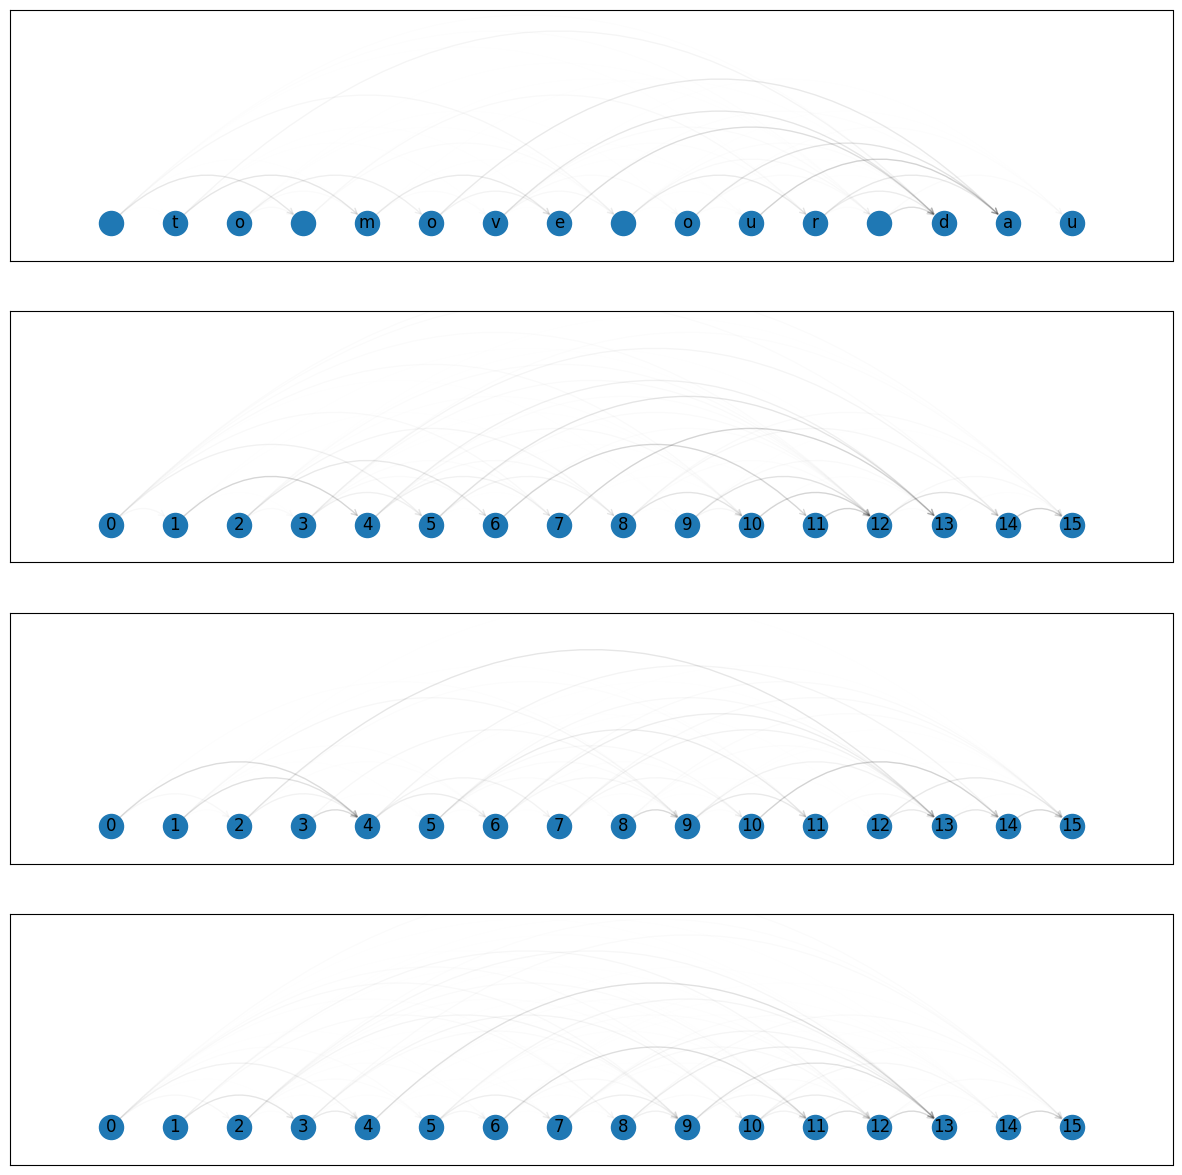

In [ ]:
fig, ax = plt.subplots(num_blocks, 1, num=1, figsize=(15, 15))

for i, (x, attn) in enumerate(zip(xs, attns)):
    ix = np.unravel_index(i, ax.shape)
    plt.sca(ax[ix])

    if i == 0:
        labels = {i: label for i, label in enumerate(decode(xb[0].tolist()))}
    else:
        labels = {i: i for i in range(xb.shape[1])}

    visualize_attention_weights(labels, attn[0].tolist()[0])

plt.show()
